In [1]:
import matplotlib.pyplot as plt
import numpy as np
from impedance.validation import linKK
from impedance import preprocessing
from impedance.visualization import plot_nyquist, plot_residuals

import re
import os
from loguru import logger


In [3]:
def gatherCSV(rootPath, outsuffix = 'Tracking'):
    ## Init element
    _filename       = None
    _filepath       = None
    _trackpath      = None
    _csvpath        = None
    _sessionIndex   = None
    _channelIndex   = None
    _processed      = None

    csvList = []

    ## Iterate session
    session_pattern = re.compile(r"(.+?)_(\d{8})_01")
    bank_pattern    = re.compile(r"([1-4])")
    file_pattern    = re.compile(r"EIS_ch(\d{3})\.csv")

    ## RootDir
    for i in os.listdir(rootPath):
        match_session = session_pattern.match(i)
        ## SessionDir
        if match_session:
            logger.info(f"Session Begin: {i}")
            _sessionIndex = match_session[2]
            for j in os.listdir(f"{rootPath}/{i}"):
                match_bank = bank_pattern.match(j)
                ## BankDir
                if match_bank:
                    logger.info(f"Bank Begin: {j}")
                    _trackpath = f"{rootPath}/{i}/{j}/{outsuffix}"
                    if not os.path.exists(_trackpath):
                        continue

                    for k in os.listdir(f"{rootPath}/{i}/{j}/{outsuffix}"):
                        match_file = file_pattern.match(k)
                        ## File
                        if match_file:
                            csvList.append(f"{rootPath}/{i}/{j}/{outsuffix}/{k}")
                            # _filename = k
                            # _filepath = f"{rootPath}/{i}/{j}/{k}"
                            # _channelIndex = (int(match_bank[1])-1)*32+int(match_file[1])
                            # if os.path.exists(f"{_trackpath}/EIS_ch{int(match_file[1]):03d}.csv") \
                            #     and os.path.exists(f"{_trackpath}/ch{int(match_file[1]):03d}.png"):
                            #     _csvpath    = f"{_trackpath}/EIS_ch{int(match_file[1]):03d}.csv"
                            #     _processed  = True
                            # else:
                            #     _csvpath    = None
                            #     _processed  = False
    return csvList

In [4]:
rootPath = "E:/Platform/Dataset/归档/01037160_归档"
csvList = gatherCSV(rootPath)

2025-01-15 19:28:40.884 | INFO     | __main__:gatherCSV:23 - Session Begin: 01037160_20241124_01
2025-01-15 19:28:40.885 | INFO     | __main__:gatherCSV:29 - Bank Begin: 1
2025-01-15 19:28:40.886 | INFO     | __main__:gatherCSV:29 - Bank Begin: 2
2025-01-15 19:28:40.887 | INFO     | __main__:gatherCSV:29 - Bank Begin: 3
2025-01-15 19:28:40.888 | INFO     | __main__:gatherCSV:29 - Bank Begin: 4
2025-01-15 19:28:40.889 | INFO     | __main__:gatherCSV:23 - Session Begin: 01037160_20241125_01
2025-01-15 19:28:40.922 | INFO     | __main__:gatherCSV:29 - Bank Begin: 1
2025-01-15 19:28:41.000 | INFO     | __main__:gatherCSV:29 - Bank Begin: 2
2025-01-15 19:28:41.263 | INFO     | __main__:gatherCSV:29 - Bank Begin: 3
2025-01-15 19:28:41.326 | INFO     | __main__:gatherCSV:29 - Bank Begin: 4
2025-01-15 19:28:41.363 | INFO     | __main__:gatherCSV:23 - Session Begin: 01037160_20241126_01
2025-01-15 19:28:41.364 | INFO     | __main__:gatherCSV:29 - Bank Begin: 1
2025-01-15 19:28:41.401 | INFO    

In [7]:
def EIS_recal(data_RC):
    f_poi = data_RC[:,0]
    Z_poi = data_RC[:,1] * np.exp(1j*np.deg2rad(data_RC[:,2]))
    Y_poi = 1/Z_poi

    Rg0 = 1.611e13
    Cp0 = 1.4e-9
    
    _Rg0_rescale = 1/Rg0*np.power(f_poi,1.583)
    _Cp0_rescale = Cp0*np.power(f_poi,0.911)
    Y_org = Y_poi - _Rg0_rescale + 1j*_Cp0_rescale
    # Y_org = Y_poi - _Rg0_rescale 
    # Y_org = Y_poi + 1j*_Cp0_rescale
    # Y_org = Y_poi
    Z_org = 1/Y_org
    return np.transpose(np.array([f_poi, np.abs(Z_org), np.rad2deg(np.angle(Z_org))]))


In [66]:
def KK_test(filePath):
    _data = np.loadtxt(filePath, delimiter=',')
    _data_re = EIS_recal(_data)
    _data_RI = tuple([_data_re[:,0], _data_re[:,1]*np.exp(1j*np.pi/180*_data_re[:,2])])

    # f_poi, Z_poi = preprocessing.ignoreBelowX(_data_RI[0], _data_RI[1])
    f_poi = _data_RI[0]
    Z_poi = _data_RI[1]
    M, mu, Z_linKK, res_real, res_imag = linKK(f_poi, Z_poi, c=0.5, max_M=100, fit_type='complex', add_cap=True)
    if 0:
        fig, axis = plt.subplots(1,1, figsize=(10,4))
        plot_residuals(axis, f_poi, res_real, res_imag)
    return np.array([f_poi, res_real, res_imag])
    

In [81]:
def gather_KKRes(csvList):
    resList = []
    for i in csvList[:100]:
        resList.append(KK_test(i))
    return np.array(resList)
def process_res(resList):
    mu = np.mean(resList,axis=0)
    std = np.std(resList,axis=0)
    score = np.sum(np.abs(resList),axis=2)
    return [mu, std, score]



In [68]:
resList = gather_KKRes(csvList)

In [88]:
resPro = process_res(resList)
resSum = [i[1]+i[2] for i in resPro[2]]

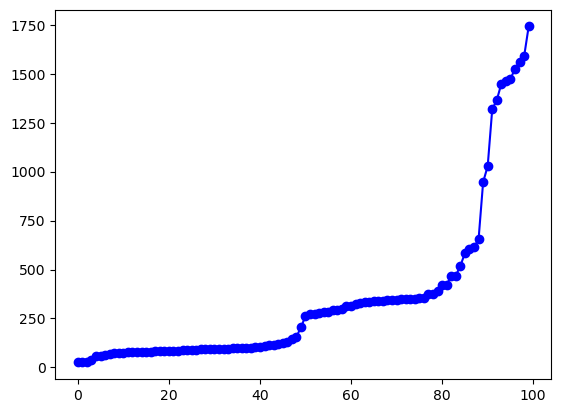

In [91]:
resSort = np.sort(resSum)

plt.plot(resSort, marker='o', linestyle='-', color='b', label='Sorted Data')

In [93]:
resSort

array([  25.04222747,   25.04726711,   25.75806509,   36.03581157,
         57.52386743,   57.57244727,   63.70425639,   70.3787858 ,
         73.84396299,   74.9419439 ,   75.46465895,   76.53372813,
         76.83833154,   77.41520667,   77.56333995,   77.97393891,
         79.96614359,   82.21858101,   82.58839595,   83.6240642 ,
         83.75356885,   86.08582523,   86.10914461,   87.91088527,
         88.04078942,   88.51060767,   89.60368857,   91.43549402,
         91.50735548,   91.63716621,   91.99171827,   92.15706584,
         92.32552317,   93.29648862,   98.38759602,   98.88649343,
        100.82643814,  101.22488142,  101.55438831,  105.568627  ,
        105.96242133,  111.04345344,  112.83351291,  113.02492211,
        120.12788675,  126.91182429,  127.36007213,  143.12100412,
        156.22681631,  204.26444827,  262.92461367,  270.40218459,
        270.85923657,  277.70378927,  280.90944585,  283.15183789,
        292.44973315,  293.12145272,  296.22559735,  312.58872